In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import levene
from scipy.stats import ttest_ind
from sqlalchemy import create_engine

In [27]:
engine = create_engine('sqlite:///nba_stats.db')
nba_player_seasons_complete = pd.read_sql("SELECT * FROM nba_player_seasons_complete", con=engine)
print(nba_player_seasons_complete.shape)
nba_player_seasons_complete.head()

(18178, 32)


,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,Year
0,4,Julius Erving,29,PHI,SF,78,78,36.1,10.7,20.7,...,4.6,7.4,4.6,2.2,1.8,3.6,2.7,26.9,"MVP-2,AS,NBA1",1980
1,17,Larry Bird,23,BOS,PF,82,82,36.0,8.5,17.8,...,7.8,10.4,4.5,1.7,0.6,3.2,3.4,21.3,"MVP-4,ROY-1,AS,NBA1",1980
2,47,Cedric Maxwell,24,BOS,SF,80,80,34.3,5.7,9.4,...,5.3,8.8,2.5,1.0,0.8,2.9,3.3,16.9,None,1980
3,63,Darryl Dawkins,23,PHI,C,80,80,31.8,6.2,11.8,...,6.2,8.7,1.9,0.6,1.8,2.9,4.1,14.7,None,1980
4,67,Dave Cowens,31,BOS,C,66,55,32.7,6.4,14.1,...,6.2,8.1,3.1,1.0,0.9,1.6,3.3,14.2,AS,1980


We’re interested in attempting to infer a player’s age using a statistical model based on performance metrics.
We might expect that when a player is relatively old or young,
there will be a relationship between their performance metrics and their age.

### Hypothesis Testing

- **Null Hypothesis ($H_0$):** There is no relationship between performance metrics and a player’s age.
- **Alternative Hypothesis ($H_1$):** There is a statistically significant relationship between performance metrics and a player’s age.

Perhaps the most straightforward performance metric is points scored (`PTS`).
We will likely expand the number of variables that constitute a player’s performance metric, but let’s start small.

In [29]:
nba_player_seasons_complete[['Age', 'PTS']].groupby('Age').mean()

,PTS
Age,
18,3.927273
19,7.274857
20,7.747309
21,8.426768
22,7.676738
23,7.709262
24,8.292023
25,8.992923
26,9.466520


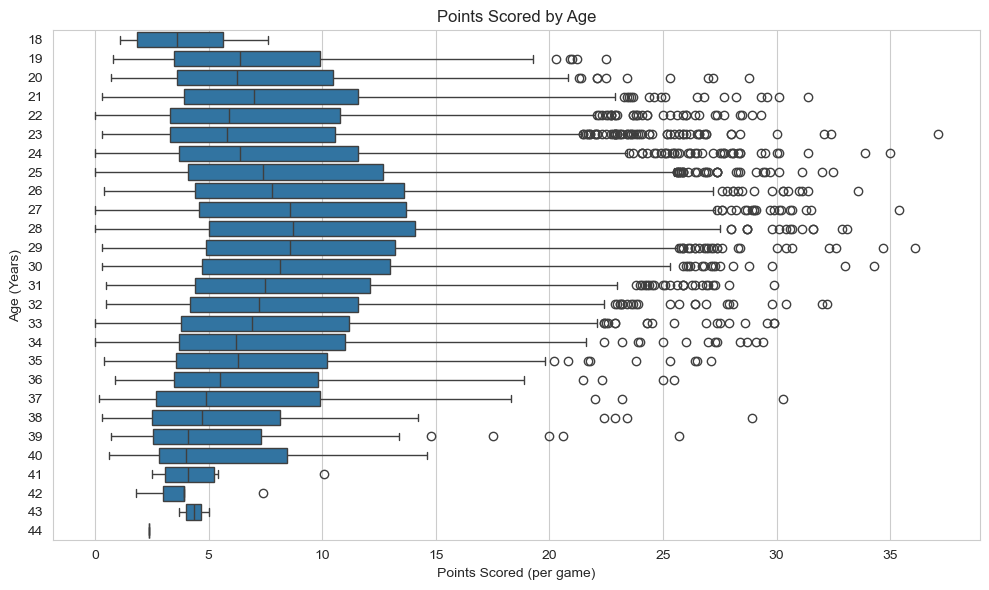

In [30]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=nba_player_seasons_complete,
    x = 'PTS',
    y = 'Age',
    orient='h'
)

plt.title('Points Scored by Age')
plt.xlabel('Points Scored (per game)')
plt.ylabel('Age (Years)')

plt.tight_layout()
plt.show()

In [72]:
# Calculate meadian player age
print("Median Player Age:", nba_player_seasons_complete['Age'].median())

# Examine age counts
nba_player_seasons_complete['Age'].value_counts()

Median Player Age: 26.0


Age
24    1918
23    1911
25    1738
26    1595
27    1444
22    1410
28    1262
29    1152
30    1032
31     867
21     721
32     714
33     568
20     446
34     421
35     295
36     206
19     175
37     129
38      87
39      43
40      19
18      11
41       6
42       5
43       2
44       1
Name: count, dtype: int64

We see that ages 18 and 38–44 have very few samples.
To maintain adequate sample sizes, we will group ≤19 as one category ("19") and ≥38 as another
("38").


In [78]:
# Make a copy to avoid altering the original dataset
nba_player_seasons_relabeled = nba_player_seasons_complete.copy()

# Group all ≤19 into 19, and all ≥38 into 38
nba_player_seasons_relabeled.loc[nba_player_seasons_relabeled['Age'] <= 19, 'Age'] = 19
nba_player_seasons_relabeled.loc[nba_player_seasons_relabeled['Age'] >= 38, 'Age'] = 38

# Separate the two groups for PTS
le_19_pts = nba_player_seasons_relabeled[nba_player_seasons_relabeled['Age'] == 19]['PTS'].values
ge_38_pts = nba_player_seasons_relabeled[nba_player_seasons_relabeled['Age'] == 38]['PTS'].values

print(f"Number of players ≤19: {len(le_19_pts)}")
print(f"Number of players ≥38: {len(ge_38_pts)}")

Number of players ≤19: 186
Number of players ≥38: 163


Both groups now have more than 100 entries, which is sufficient for our purposes.

Next, let's bootstrap the mean points per game for each group to visualize the distribution of their means.

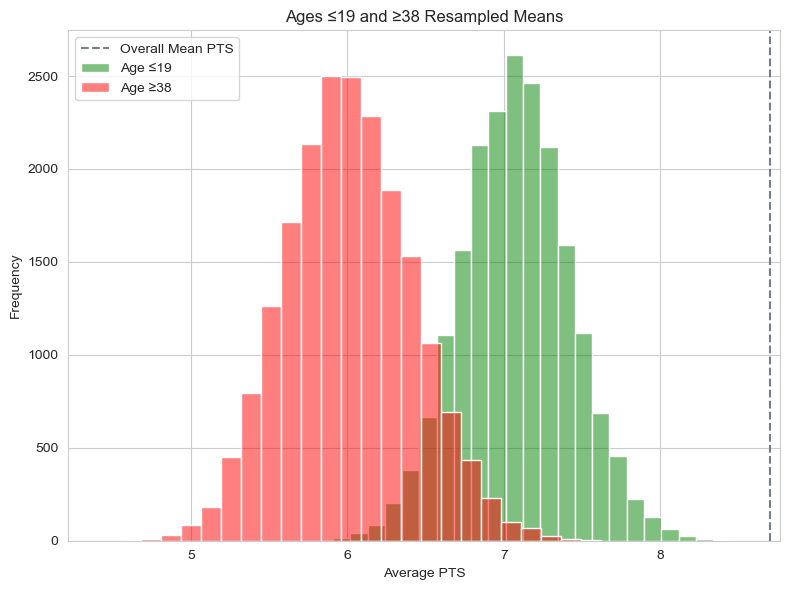

In [79]:
# Full dataset's mean PTS (used as a vertical reference line)
age_pts = nba_player_seasons_relabeled['PTS'].values
age_pts_mean = age_pts.mean()

# Resample means for each group
le_19_means = []
ge_38_means = []

for _ in range(20_000):
    le_19_resamp = np.random.choice(le_19_pts, size=len(le_19_pts), replace=True)
    ge_38_resamp = np.random.choice(ge_38_pts, size=len(ge_38_pts), replace=True)

    le_19_means.append(le_19_resamp.mean())
    ge_38_means.append(ge_38_resamp.mean())

le_19_means = np.array(le_19_means)
ge_38_means = np.array(ge_38_means)

plt.figure(figsize=(8, 6))
sns.histplot(le_19_means, bins=25, color="green", alpha=0.5, label="Age ≤19")
sns.histplot(ge_38_means, bins=25, color="red", alpha=0.5, label="Age ≥38")
plt.axvline(x=age_pts_mean, color="slategrey", linestyle="--", label="Overall Mean PTS")

plt.title("Ages ≤19 and ≥38 Resampled Means")
plt.xlabel("Average PTS")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

The bootstrap distributions show the sampling variability of mean `PTS` for each group.
Next, we formally test for a difference in means using a two-sample t-test.

### Assumptions and Potential Biases:
- Prior to 2006, NBA prospects were able to enter the league out of high school. Nowadays, players must be 19 years old to be eligible for the draft. This introduces some potential biases. It has been almost 20 years since an 18-year-old has played in the NBA, so the statistics could be misrepresentative of trends or changes in the NBA.
- Players who did get drafted out of high school as an 18-year-old were likely to be exceptional prospects and potentially may not be representative of the broader population.
- 18-year-old players likely do not have the complete performance data because they most likely played their first NBA games at least a few months after turning 18. Similarly, players in their 40s might be subject to missing or incomplete data due to reduced roles and/or playing time.
- The few players who have careers that last into their 40s are likely to be generational talents, potentially introducing survivorship bias.
- For 18-year-olds and players in their 40s, the small sample sizes introduce higher variability and reduced statistical power because there is simply less data available to work with.

First, we check if variances are equal using Levene’s Test.
If the p-value from the t-test is below our chosen significance level (0.05),
we reject the null hypothesis, concluding there is a statistically significant difference in mean PTS between these age groups.

In [83]:
f_stat, p_val_levene = levene(le_19_pts, ge_38_pts, center='mean')
print(f"Levene's Test: F={f_stat:.4f}, p-value={p_val_levene:.4f}")

# Decide which t-test to use
if p_val_levene < 0.05:
    print("\n*Variances are not equal — using Welch’s t-test.*")
    t_stat, p_val_ttest = ttest_ind(le_19_pts, ge_38_pts, equal_var=False)
else:
    print("\n*Variances are equal — using Student’s t-test.*")
    t_stat, p_val_ttest = ttest_ind(le_19_pts, ge_38_pts, equal_var=True)

print(f"\nT-test: statistic={t_stat:.3f}, p-value={p_val_ttest:.3f}")

Levene's Test: F=0.0021, p-value=0.9632

*Variances are equal — using Student’s t-test.*

T-test: statistic=1.999, p-value=0.046


Since p > 0.05, the variances are equal, and we use the standard (Student’s) two-sample t-test.

Because p < 0.05, we reject the null hypothesis.

We used bootstrapping and a t-test to assess whether there is a difference in average PTS for these edge groups.
The test suggested a statistically significant difference (p-value < 0.05).
While this indicates that players ≤19 and ≥38 differ in mean PTS, these two subsets represent relatively rare age extremes.
Before finalizing conclusions, we extend our analysis to additional metrics and the broader age distribution.

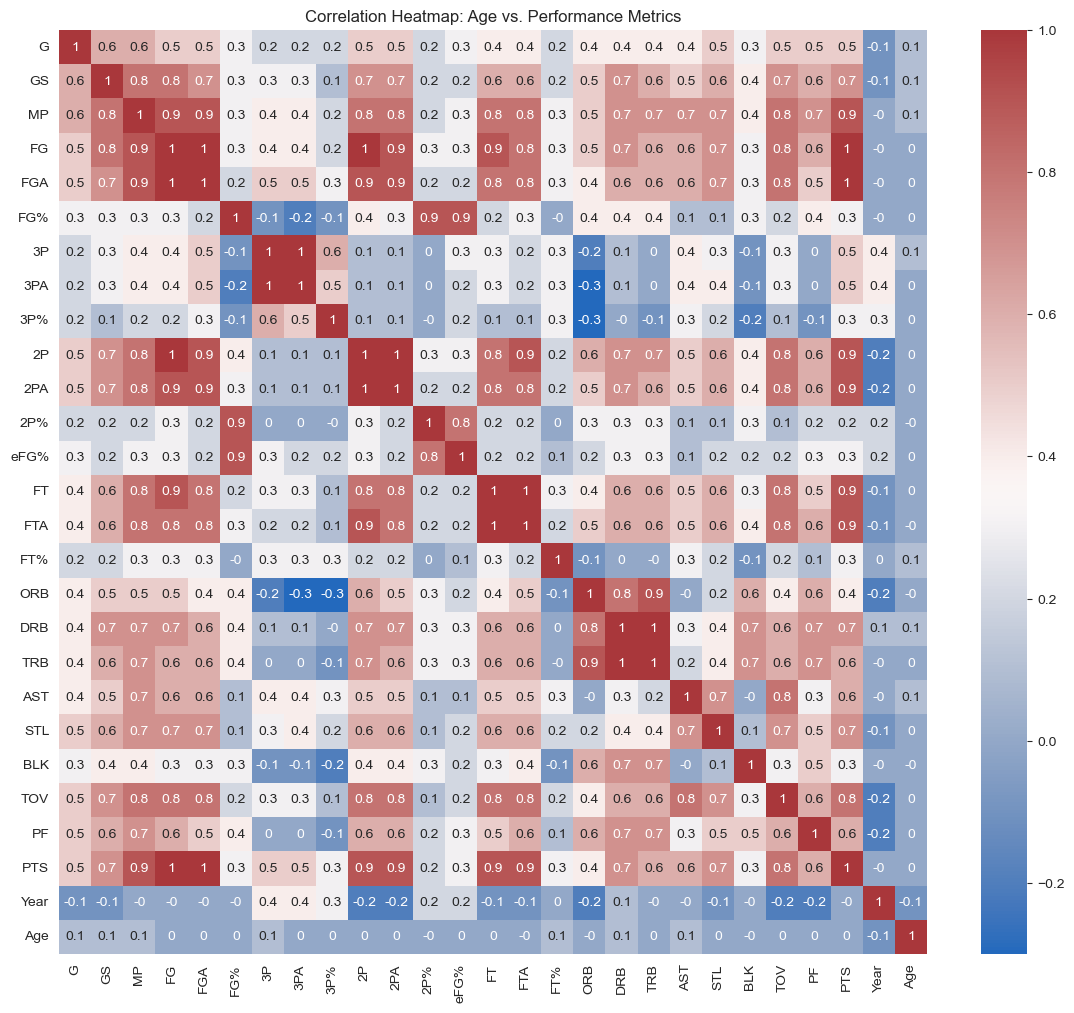

In [97]:
target = 'Age'
features = [
    'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
    '3P', '3PA', '3P%', '2P', '2PA', '2P%',
    'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
    'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
    'PTS', 'Year'
]

nba_corr_subset = nba_player_seasons_complete[features + [target]]
nba_corrs = nba_corr_subset.corr().round(1)

plt.figure(figsize=(14, 12))
sns.heatmap(nba_corrs, annot=True, cmap="vlag")
plt.title("Correlation Heatmap: Age vs. Performance Metrics")
plt.show()

From this heatmap, we can see that `Age` does not have a very strong correlation (positive or negative) with most of these metrics.
Even the correlation with `PTS` appears small.

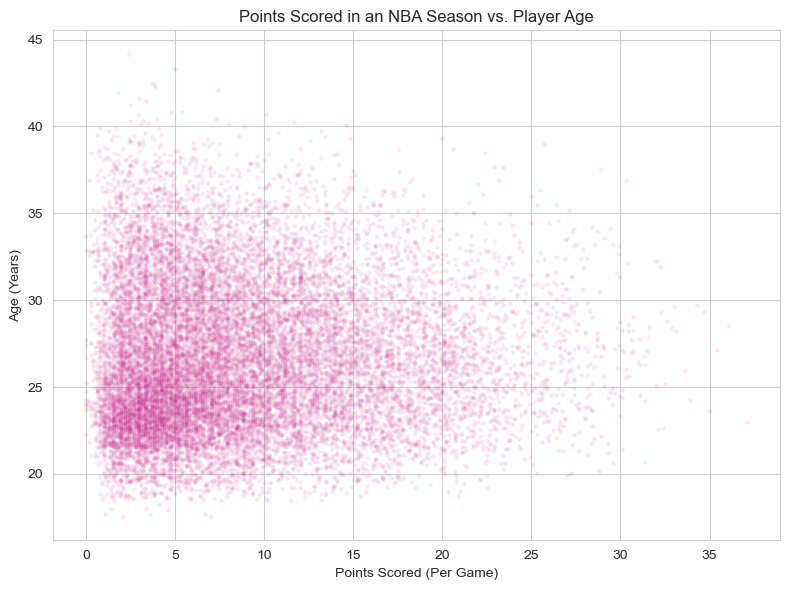

In [98]:
def add_jitter(data, column, jitter_amount=0.5):
    return data[column] + np.random.uniform(-jitter_amount, jitter_amount, size=len(data))

plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=nba_corr_subset,
    x='PTS',
    y=add_jitter(nba_corr_subset, 'Age'),
    color='mediumvioletred',
    s=10,
    alpha=0.1,
)

plt.title('Points Scored in an NBA Season vs. Player Age')
plt.xlabel('Points Scored (Per Game)')
plt.ylabel('Age (Years)')
plt.tight_layout()
plt.show()


Visually, there is a large spread of points across all ages. Any linear trend between `PTS` and `Age` appears subtle.
To quantify this, let's fit a simple linear regression model where `PTS` is the predictor and `Age` is the response.


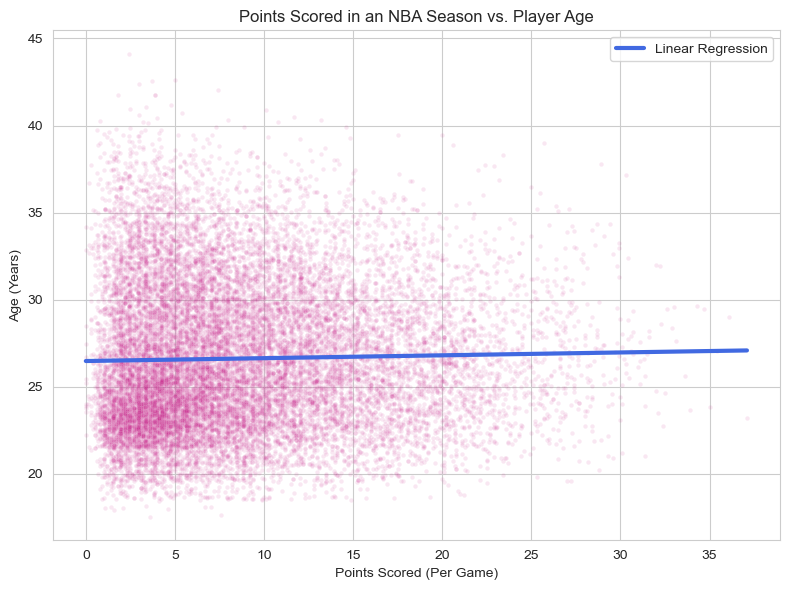

In [99]:
xs = np.linspace(np.min(nba_player_seasons_complete['PTS']), np.max(nba_player_seasons_complete['PTS']), 100)

lin_reg_model = LinearRegression()
lin_reg = lin_reg_model.fit(nba_player_seasons_complete[['PTS']], nba_player_seasons_complete['Age'])

b0 = lin_reg.intercept_
b1 = lin_reg.coef_[0]

preds = b0 + b1 * xs

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=nba_corr_subset,
    x='PTS',
    y=add_jitter(nba_corr_subset, 'Age'),
    color='mediumvioletred',
    s=10,
    alpha=0.1,
)
sns.lineplot(
    x=xs,
    y=preds,
    color='royalblue',
    linewidth=3,
    label='Linear Regression',
)

plt.title('Points Scored in an NBA Season vs. Player Age')
plt.xlabel('Points Scored (Per Game)')
plt.ylabel('Age (Years)')
plt.legend()
plt.tight_layout()
plt.show()

Next,let’s evaluate this simple linear regression model using `StatsModels` to get an **R-squared** and other metrics.

In [101]:
X = nba_player_seasons_complete[['PTS']]
X = sm.add_constant(X)
sm_model = sm.OLS(nba_player_seasons_complete['Age'], X).fit()
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.70
Date:                Mon, 17 Mar 2025   Prob (F-statistic):            0.00107
Time:                        17:47:57   Log-Likelihood:                -51518.
No. Observations:               18178   AIC:                         1.030e+05
Df Residuals:                   18176   BIC:                         1.031e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.4734      0.053    497.319      0.0

## Observations

- The **R-squared** for this simple model is ~0.001, indicating that **PTS** alone explains very little of the variance in **Age**.
- Despite our t-tests showing a difference in mean PTS at the extreme age groups (≤19 vs. ≥38), the overall linear relationship across all ages is weak.
- This highlights the complexity of using a single metric (PTS) to explain age or vice versa.

### Next Steps

1. **Consider Multiple Metrics**: We have over 30 features (e.g., rebounds, assists, FG%, etc.). A more sophisticated model (like a multiple linear regression or another ML algorithm) may better capture how age interacts with various performance metrics.
2. **Refine Age Group Analysis**: Instead of only comparing extreme groups, we might compare more nuanced age brackets (e.g., early 20s, mid-20s, late 20s, early 30s, etc.) to see if the differences in performance are more pronounced in certain ranges.
3. **Account for Confounders**: Metrics like minutes played, injuries, and role on a team can affect both age-related trends and performance. Controlling for these could yield clearer insights.

At this point, we do not draw a final conclusion about the relationship between age and performance across the league.
The t-tests on extreme age groups show a difference in mean PTS, but the overall correlation between age and points is very weak.
Our next step is to incorporate multiple metrics and more nuanced approaches to better understand how (and if) age truly impacts performance.
